# Elo model

Reads in historical data we downloaded from football-data.co.uk and builds a predictive model for the Premiership season 2016-2017 based on past Elo ratings. There are some initial parameters that need to be looked at in more detail to get better results. We can also add things such as home advantage, goals scored etc. to the Elo update rule which would hopefully give better results.

### Parameters to tune:

- What season do we start calculating Elo? (call this the "training" part of the model)
- Elo K-factor adjustment, affects how a team's Elo gets rescaled upon win/losing
- Elo initialisation differences to capture the difference in skill between leagues 

# Import data

In [416]:
import os
import pandas as pd
import numpy as np
data_path = "./data/" 
dic = {}

cols = ["Div","Date","HomeTeam","AwayTeam",
       "FTHG","FTAG","FTR","HTHG","HTAG","HTR"
]

matches = pd.DataFrame(None,columns=cols) # Empty dataframe we'll add the data to

for f in [x for x in os.listdir(data_path)]: #if "prem" in x]:
    print(f)
    results_df = pd.read_csv(data_path+f,usecols=cols,parse_dates=True)
    results_df = results_df.dropna(how="all") # kill empty last rows, below tests this isn't deleting any matches
    
    if f.split("_")[0] == "prem": # premiership, 20 teams play each other twice, 20*19 total matches
        assert len(results_df) == 20*19
    else:
        assert len(results_df) == 24*23 # lower leagues, 24 teams play 2x, 24*23 total
    
    results_df["Season"] = (f.split("_")[-1].split(".")[0])
    results_df["Season"] = results_df["Season"]
    
    matches = pd.concat([results_df,matches])

# reorder data by date
matches["Date"] = pd.to_datetime(matches["Date"],dayfirst=True)
matches = matches.sort_values(by="Date")
matches = matches.reset_index(drop=True)
print("==="*3)
print(matches.head())

prem_0910.csv
prem_1314.csv
league_1_0910.csv
champ_0910.csv
league_2_1213.csv
league_2_1112.csv
champ_1314.csv
prem_1617.csv
league_1_1112.csv
league_1_1213.csv
league_2_1011.csv
league_2_1516.csv
league_2_1415.csv
league_1_1011.csv
league_1_1415.csv
league_2_0910.csv
prem_1011.csv
prem_1213.csv
league_2_1617.csv
champ_1011.csv
champ_1213.csv
champ_1516.csv
league_1_1617.csv
prem_1112.csv
champ_1415.csv
champ_1112.csv
champ_1617.csv
league_1_1314.csv
league_1_1516.csv
league_2_1314.csv
prem_1415.csv
prem_1516.csv
           AwayTeam       Date Div FTAG FTHG FTR HTAG HTHG HTR       HomeTeam  \
0  Sheffield United 2009-08-07  E1    0    0   D    0    0   D  Middlesbrough   
1         Peterboro 2009-08-08  E1    1    2   H    0    1   H          Derby   
2           Swansea 2009-08-08  E1    1    2   H    1    0   A      Leicester   
3      Bristol City 2009-08-08  E1    2    2   D    0    0   D        Preston   
4         Blackpool 2009-08-08  E1    1    1   D    1    0   A            Q

# Train model

Initalise Elo for each team depending on its league (higher league = higher initial Elo). Run through some past match data to update this to more accurate values (not too far into the past though, we want to capture recent form with a higher priority so limit to last few seasons only).

We will predict for the Premiership season 2016-2017.

In [418]:
### PARAMETERS
k = 20 # k_factor, scales ELO change, 32 = chess k_factor

train_start_date = pd.to_datetime("01/08/2013",dayfirst=True)
predict_start_date = pd.to_datetime("01/08/2016",dayfirst=True)
#####

# initialise ELOs, scale for league
starting_league = matches.loc[matches["Season"] == matches["Season"].min()] # Earliest season
teams_init = {}
for team in matches["HomeTeam"].unique():
    if team not in list(teams_init.keys()):
        try:
            team_starting_league = starting_league.loc[starting_league["HomeTeam"] == team]["Div"].mode()[0]
#             print(team_starting_league)
            if team_starting_league == "E3":
                teams_init[team] = 250
            elif team_starting_league == "E2":
                teams_init[team] = 500
            elif team_starting_league == "E1":
                teams_init[team] = 1500
            elif team_starting_league == "E0":
                teams_init[team] = 2500
        except: #must be lower than conference, give 0
            teams_init[team] = 0
            
# Setup train/test split
historical_matches = matches.loc[(matches["Date"] < predict_start_date)&(matches["Date"] > train_start_date)]
# Get 2016-2017 premiership matches
future_matches = matches.loc[matches["Date"] > predict_start_date] # 2016-2017 season
future_matches = future_matches.loc[future_matches["Div"] == "E0"] # get premiership matches only

# Run through past matches, update Elo for everyone
for index,match in historical_matches.iterrows():
    home_team = match["HomeTeam"]
    away_team = match["AwayTeam"]
    rating_home = teams_init[home_team]
    rating_away = teams_init[away_team]
    
    teams_init[home_team], teams_init[away_team] = update_elo(rating_home,rating_away,match["FTR"])

## Predict on 16/17


In [419]:

import copy

iters = 1000 # number of season simulations to run 

prem_teams = future_matches["HomeTeam"].unique() # list of premiership teams, used for creating dataframes
simulation_results = pd.DataFrame(index=prem_teams) # holds results, we will append to this

for j in range(iters):

    table = {team : 0 for team in prem_teams} # initialise league table 
    
    teams = copy.deepcopy(teams_init) # makes sure we are resetting the Elo at the start of each season
    
    for index,match in future_matches[["HomeTeam","AwayTeam"]].iterrows(): # run simulation

        home_team = match["HomeTeam"]
        away_team = match["AwayTeam"]
        rating_home = teams[home_team]
        rating_away = teams[away_team]

        q_home = 10**(rating_home/400)
        q_away = 10**(rating_away/400)

        e_home =  q_home/(q_home + q_away)# expected value home wins
        e_away =  q_away/(q_home + q_away) 

        ## 
        probabilities = [e_home**2,2*e_home*e_away,e_away**2] # Square e_home+e_away to make up p_draw - Elo DOESNT give you this by default
        result = np.random.choice(["H","D","A"],p=probabilities)
        teams[home_team], teams[away_team] = update_elo(teams[home_team],teams[away_team],result)

        #Update league table
        if result == "H":
            table[home_team] += 3
        elif result == "A":
            table[away_team] += 3
        elif result == "D":
            table[home_team] += 1
            table[away_team] += 1

    # add this simulated season results to our records
    table = pd.DataFrame(table,index=range(1)).T.sort_values(by=0,ascending=False)
    table.columns = [j]
    simulation_results = pd.concat([simulation_results,table],axis=1)

In [420]:
# Take mean over all simulations
simulated_table = simulation_results.mean(axis=1).astype(int).sort_values(ascending=False).reset_index()
simulated_table.columns = ["Sim_team","Sim_pts"]

## Get actual results

In [424]:
# Creates actual results table from the real 2016-2017 premiership season, prints comparison

actual_table = {team: 0 for team in prem_teams}

for index,match in future_matches[["HomeTeam","AwayTeam","FTR"]].iterrows():

    home_team = match["HomeTeam"]
    away_team = match["AwayTeam"]
    result = match["FTR"]

    if result == "H":
        actual_table[home_team] += 3
    elif result == "A":
        actual_table[away_team] += 3
    elif result == "D":
        actual_table[home_team] += 1
        actual_table[away_team] += 1
        
actual_table = pd.DataFrame(actual_table,index=range(1)).T.sort_values(by=0,ascending=False).reset_index()
actual_table.columns = ["Act_team","Act_pts"]
res = pd.concat([simulated_table,actual_table],axis=1)
print(res)

          Sim_team  Sim_pts        Act_team  Act_pts
0          Arsenal       86         Chelsea       93
1         Man City       84       Tottenham       86
2          Chelsea       80        Man City       78
3        Tottenham       80       Liverpool       76
4       Man United       79         Arsenal       75
5        Liverpool       77      Man United       69
6         West Ham       68         Everton       61
7            Stoke       64     Bournemouth       46
8          Everton       63     Southampton       46
9       Sunderland       55       West Brom       45
10       Leicester       54        West Ham       45
11         Burnley       43       Leicester       44
12         Swansea       40           Stoke       44
13       West Brom       34  Crystal Palace       41
14            Hull       34         Swansea       41
15  Crystal Palace       33         Burnley       40
16         Watford       20         Watford       40
17     Southampton       16            Hull   

## Histogram of simulated points - actual points for each team

(array([ 0.,  1.,  4.,  3.,  5.,  3.,  2.,  1.]),
 array([-40, -30, -20, -10,   0,  10,  20,  30,  40]),
 <a list of 8 Patch objects>)

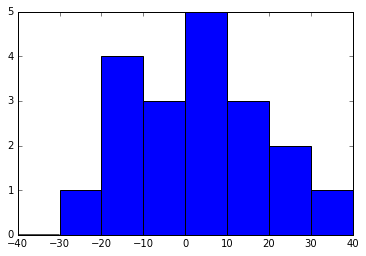

In [422]:
import matplotlib.pylab as plt
%matplotlib inline
# (simulated_table.to_dict())
diff = simulated_table.sort_values(by="Sim_team")["Sim_pts"].values - actual_table.sort_values(by="Act_team")["Act_pts"].values
plt.hist(diff,bins=range(-40,50,10))

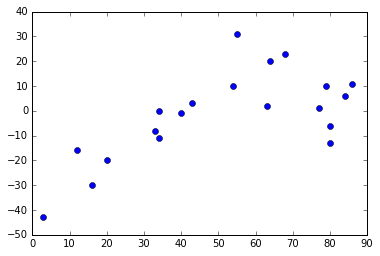

In [423]:
plt.plot(simulated_table.sort_values(by="Sim_team")["Sim_pts"].values,diff,"o")